In [1]:
import sys
import os
sys.path.append('../src')
import joblib
import pandas as pd
import numpy as np

# Load processed credit card features
from data_processing import DataLoader
from interpretablility import Explainer
from modeling import Modeling

import shap
import matplotlib.pyplot as plt

Load the data

In [2]:
loader = DataLoader("../data/processed/creditcard_cleaned.csv")
df = loader.load_data()

DROP_COLS = [
    "Class"
]

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df["Class"]
print("Fraud rate:", y.mean())


Fraud rate: 0.001667101358352777


### Re-run data split to maintain index consistency

In [3]:
fraud_model = Modeling()
fraud_model.prepare_data(X, y)
X_test, X_train = fraud_model.X_test, fraud_model.X_train
y_test, y_train = fraud_model.y_test, fraud_model.y_train


### Load Random Forest Model

In [4]:
rf_pipeline = joblib.load("../models/random_forest_creditcard.pkl")
model = rf_pipeline.named_steps['model']

### Baseline Feature Importance

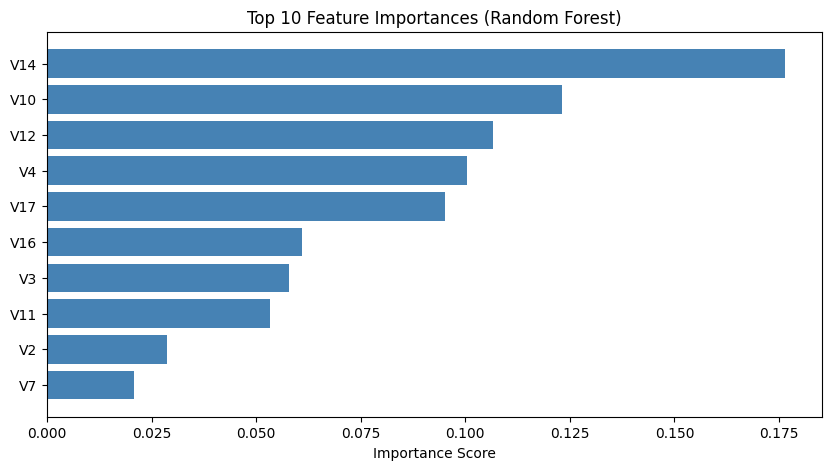

In [5]:
feature_importance = pd.DataFrame({
    "feature": X_test.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance.head(10)["feature"], feature_importance.head(10)["importance"], color='steelblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

#### Initialize SHAP TreeExplainer

In [6]:
explainer = Explainer(model, X_train, X_test)

The SHAP explainer is initialized using a tree-based explainer suitable for Random Forest models. To improve computational efficiency, global SHAP values are computed on a representative sample of transactions, while local explanations use individual observations.

In [7]:
explainer.compute_shap_sample()


### SHAP Global Explanation

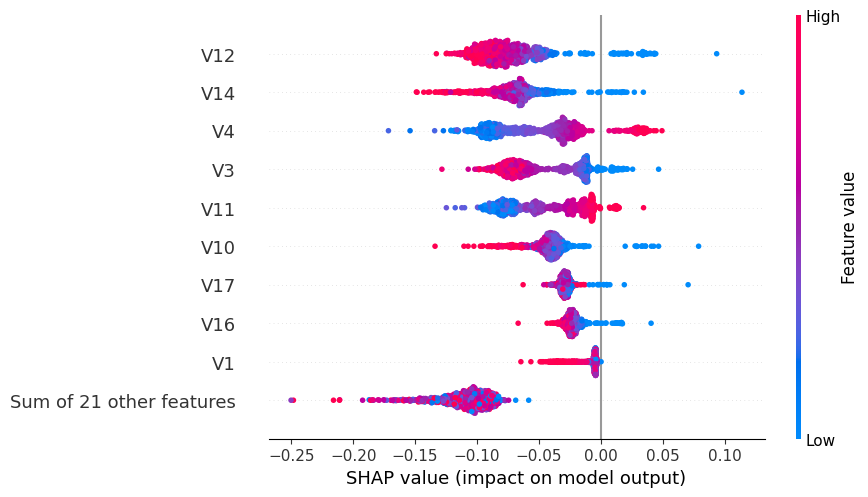

In [8]:
# Summary Plot
explainer.plot_global_summary()

### Identify TP, FP, FN Cases

In [9]:
y_pred = model.predict(X_test)
results = X_test.copy()
results["actual"] = y_test.values
results["predicted"] = y_pred

# True Positive, False Positive, False Negative indices
tp_idx = results[(results.actual == 1) & (results.predicted == 1)].index[0]
fp_idx = results[(results.actual == 0) & (results.predicted == 1)].index[0]
fn_idx = results[(results.actual == 1) & (results.predicted == 0)].index[0]

print(f"Indices Selected - TP: {tp_idx}, FP: {fp_idx}, FN: {fn_idx}")

Indices Selected - TP: 115676, FP: 119616, FN: 239334


### SHAP Plot - True Positive (Caught Fraud)

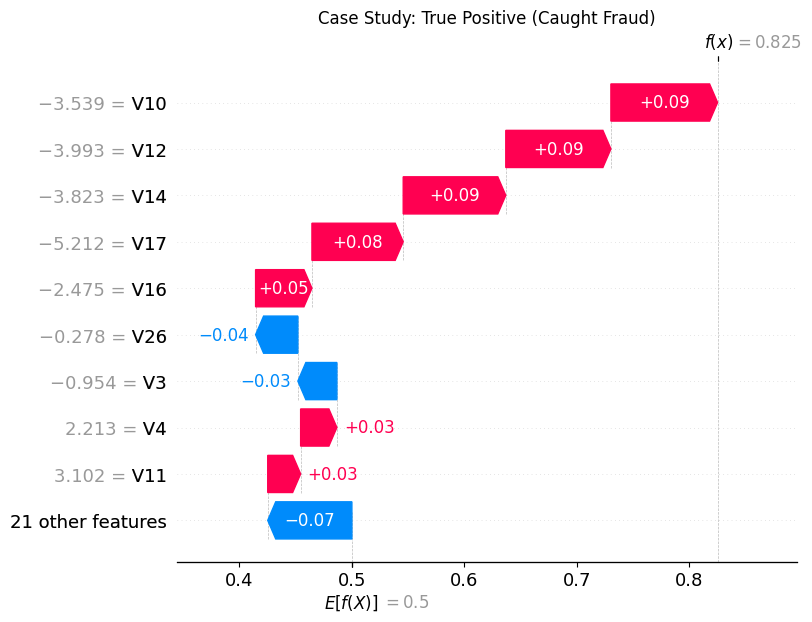

<Figure size 640x480 with 0 Axes>

In [10]:
explainer.plot_waterfall(tp_idx, "Case Study: True Positive (Caught Fraud)")

#### SHAP Plot - False Positive (Customer Friction)

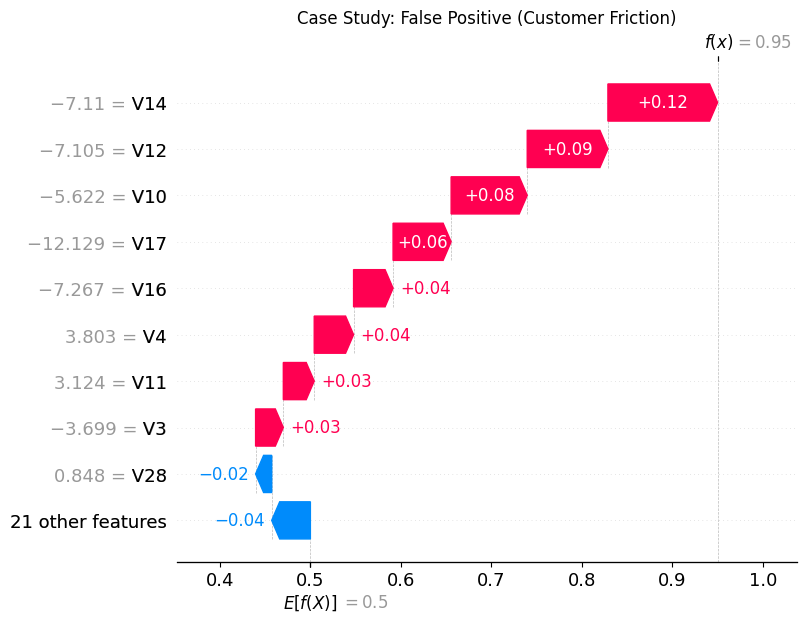

<Figure size 640x480 with 0 Axes>

In [11]:
explainer.plot_waterfall(fp_idx, "Case Study: False Positive (Customer Friction)")

#### SHAP Plot - False Positive (Customer Friction)

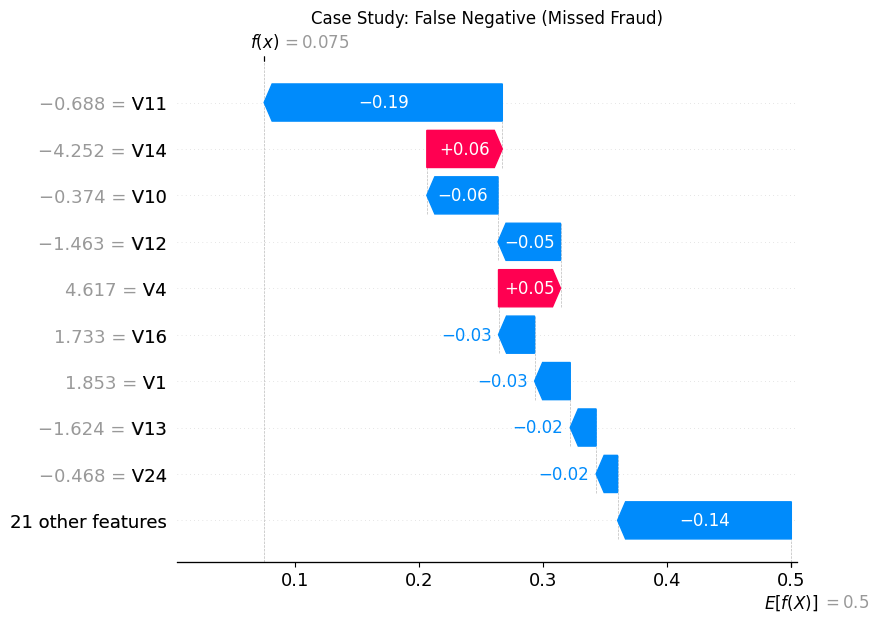

<Figure size 640x480 with 0 Axes>

In [12]:

explainer.plot_waterfall(fn_idx, "Case Study: False Negative (Missed Fraud)")

### SHAP Dependence Plot

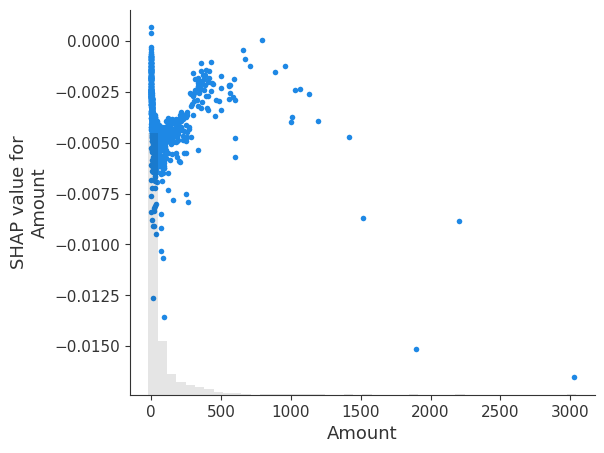

In [13]:
explainer.plot_dependence("Amount")

### Business Recommendaton

* Component-Based Precision Alerts: Configure real-time alerts for the 99th percentile of V17 and V14 scores. Transactions in this range are almost 100% fraudulent based on SHAP clustering.

* Low-Value Micro-Clustering: To catch the False Negatives (test charges), implement a secondary model that monitors for 3+ small-value transactions ($1-$5) occurring within 60 seconds.

* Explainable Review Dashboards: Provide SHAP Waterfall plots to the manual review team. Instead of seeing a "Risk Score: 85%," analysts can see "Risk: High due to V17 (Location Anomaly)," allowing for faster, more accurate decisions.